In [1]:
# Here we take care of paths.

from pathlib import Path
import os
print('Starting path:' + os.getcwd())
if os.getcwd()[-16:] == 'image-to-tex-OCR':
    pass
else:
    PATH = Path().resolve().parents[0]
    os.chdir(PATH)

# make sure you are in Paragraph_to_Tex folder
print('Current path:' + os.getcwd())

Starting path:/Users/gregory/PROJECT_ML/PROJECT_AMINE/image-to-tex-OCR/Jupyter_Notebooks
Current path:/Users/gregory/PROJECT_ML/PROJECT_AMINE/image-to-tex-OCR


In [2]:
from Data.Data_Module import Data_Module
from Models.Printed_Tex_Transformer import ResNetTransformer
from Lightning_Models.Printed_Tex_Lit_Model import LitResNetTransformer
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from PIL import Image
import torch
from pytorch_lightning.loggers import TensorBoardLogger
from torchvision import transforms
from PIL import Image
from IPython.display import display, Math
from Data.image_transforms import Image_Transforms
import cv2
import cv2
import PIL
import numpy as np
transform = transforms.ToPILImage()



dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


In [3]:
# Generate Data Module by uploading images and formulas
# images need to be in the folder Data/Data_Bank/generated_png_images
# formulas need to be in Data/Data_Bank/final_png_formulas.txt
# image filenames need to be in Data/Data_Bank/corresponding_png_images.txt

dataset = Data_Module(stage = 'fit',
                 set_max_label_length = 128,
                 number_png_images_to_use_in_dataset=250*1000,
                 labels_transform='default',
                image_transform_name ='alb',
                 train_val_fraction = 0.999,
                   vocabulary_path = 'Tokenizer/230k_ver2.json',
                load_vocabulary = True,
                      image_padding = True,
                      max_width = 10*1000,


                 batch_size = 128,
                num_workers = 8,
                data_on_gpu = True,
                )

In [4]:
print( 
    'Vocabulary size:',len(dataset.vocabulary),
    '\nMax label length:', dataset.max_label_length,
    "\nStart <S> goes to index ",dataset.vocabulary['<S>'],
      "\nEnd <E> goes to index ",dataset.vocabulary['<E>'],
      "\nPadding <P> goes to index ",dataset.vocabulary['<P>'],
)

Vocabulary size: 581 
Max label length: 130 
Start <S> goes to index  0 
End <E> goes to index  1 
Padding <P> goes to index  2


In [5]:


# HELPER FUNCTIONS
def token_to_strings(tokens):
    mapping = dataset.vocabulary
    inverse_mapping =dataset.inverse_vocabulary
    s=''
    if tokens.shape[0] ==1:
        tokens = tokens[0]
    for number in tokens:
        letter = inverse_mapping[number.item()]
        s= s +" " + str(letter)
    return s

In [6]:
model = ResNetTransformer(dataset=dataset).to(dev)
model.load_state_dict(torch.load(("Models_Parameters_Log/Ver1_64Height_10ratio_resnet18_3layers.pth"), map_location=torch.device('cpu')))
lit_model = LitResNetTransformer(model=model, WandB=False)
lit_model.eval()
lit_model.freeze()
scripted_save = lit_model.to_torchscript()
torch.jit.save(scripted_save, "Models_Parameters_Log/scripted_model1.pt")


/Users/gregory/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/gregory/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/Users/gregory/opt/anaconda3/lib/python3.9/site-packages/torch/jit/_recursive.py:262: UserWarning: 'batch_first' was found in ScriptModule constants, but was not actually set in __init__. Consider removing it.
  warnings.warn("'{}' was found in ScriptModule constants, "


In [7]:
scripted = torch.jit.load("Models_Parameters_Log/scripted_model1.pt")

In [8]:
import albumentations
from albumentations.augmentations.geometric.resize import Resize
import torch.nn.functional as F

MAX_RATIO = 10
GOAL_HEIGHT = 64

def find_ratio(h, w, goal):
    return goal/h
    

def predict_new(image_path):
    MAX_RATIO = 12
    image = Image.open(image_path).convert('RGB')
    image = np.asarray(image)
    h, w, c = image.shape
    ascpect = w/h
    if ascpect == 0:
        ascpect = 1 
    if ascpect > MAX_RATIO:
        ascpect = MAX_RATIO
    
    downscale = GOAL_HEIGHT/h
    image = cv2.resize(image, (0,0), fx=downscale, fy=downscale,interpolation=cv2.INTER_LINEAR)
   
    print(image.shape)


    
    image_tensor = Image_Transforms.test_transform_with_padding(image =np.array(image))['image'][:1]
    print(display(transform(image_tensor)))
    print(image_tensor.shape)
    print('\nPredicted formula:')
    prediction =  scripted(image_tensor.unsqueeze(0))
    print(token_to_strings(prediction))
    print(display(Math(token_to_strings(prediction))))

def predict(image_path):
   
    image = Image.open(image_path).convert('RGB')
    image = np.asarray(image)
    h, w, c = image.shape
    ratio =w / h
    if ratio == 0:
        ratio = 1 
    if ratio > MAX_RATIO:
        ratio = MAX_RATIO
        
    new_h = GOAL_HEIGHT
    new_w = int(new_h * ratio)
    image = Resize(interpolation= cv2.INTER_LINEAR,height=new_h, width= new_w, always_apply=True)(image=image)['image']
    print(image.shape)


    
    image_tensor = Image_Transforms.test_transform_with_padding(image =np.array(image))['image'][:1]
    print(display(transform(image_tensor)))
    
    print(image_tensor.shape)
    print('\nPredicted formula:')
    prediction =  scripted(image_tensor.unsqueeze(0))
    print(token_to_strings(prediction))
    print(display(Math(token_to_strings(prediction))))

# HELPER FUNCTIONS
def token_to_strings(tokens):
    mapping = dataset.vocabulary
    inverse_mapping =dataset.inverse_vocabulary
    s=''
    if tokens.shape[0] ==1:
        tokens = tokens[0]
    for number in tokens:
        letter = inverse_mapping[number.item()]
        s= s +" " + str(letter)
    return s
    

In [16]:
IMAGES= ['Jupyter_Notebooks/test_photos/79a37d9d8b727e9.png',
         "Jupyter_Notebooks/test_photos/0a0df4c4229b725.png",
         "Jupyter_Notebooks/test_photos/zarhin.png",
         "Jupyter_Notebooks/test_photos/my_image.png",
         "Jupyter_Notebooks/test_photos/screenshot_1.png",
         "Jupyter_Notebooks/test_photos/screenshot_3.png",
         "Jupyter_Notebooks/test_photos/Screen Shot_14.png",
         "Jupyter_Notebooks/test_photos/Screen Shot_10.png",
         "Jupyter_Notebooks/test_photos/Screen Shot_13.png",
          "Jupyter_Notebooks/test_photos/Screen Shot_11.png",
         "Jupyter_Notebooks/test_photos/screenshot_2.png",
         "Jupyter_Notebooks/test_photos/Screen Shot_18.png",
        'Jupyter_Notebooks/test_photos/128.png',
         'Jupyter_Notebooks/test_photos/128_2.png',
         'Jupyter_Notebooks/test_photos/image_3.png',
         'Jupyter_Notebooks/test_photos/Screen Shot_15.png',
         'Jupyter_Notebooks/test_photos/Screen Shot_11.png',
         'Jupyter_Notebooks/test_photos/Screen Shot_16.png',
         'Jupyter_Notebooks/test_photos/Screen Shot_17.png',
         'Jupyter_Notebooks/test_photos/screenshot_2.png',
         
         
    

]

(64, 640, 3)


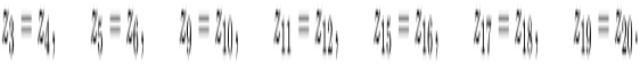

None
torch.Size([1, 64, 640])

Predicted formula:
 <S> \psi \rangle \equiv ^ { w } \psi _ { 0 } \qquad \psi _ { 0 } \equiv \stackrel { w } { w } \partial _ { 0 } \qquad \psi | 0 | \qquad \delta \rangle = W | 0 | 0 | \qquad \delta | 0 | 0 | \qquad \delta | 0 | 0 | \qquad \delta | 0 | 0 | \qquad \quad \quad \quad \quad \quad \delta \rangle <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(64, 277, 3)


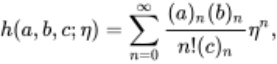

None
torch.Size([1, 64, 277])

Predicted formula:
 <S> h ( a , b , c ; \eta ) = \sum _ { n = 0 } ^ { \infty } \frac { ( a ) _ { n } ( b ) _ { n } ( b ) _ { n } { n ! ( c ) _ { n } } \eta ( c ) _ { n } } \eta ^ { n ( c ) _ { n } } \eta ^ { n } , <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(64, 284, 3)


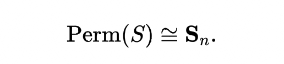

None
torch.Size([1, 64, 284])

Predicted formula:
 <S> \mathrm { P e r m } ( S ) \cong { \bf S } _ { n } ( S ) \cong { \bf S } _ { n } . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(64, 242, 3)


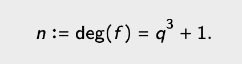

None
torch.Size([1, 64, 242])

Predicted formula:
 <S> m : = \mathrm { d e g } ( f ) = q ^ { 3 } + { \bf r } ^ { 3 } + { \bf r } ^ { 3 } + { \bf r } . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(64, 277, 3)


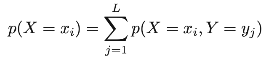

None
torch.Size([1, 64, 277])

Predicted formula:
 <S> p ( X = x _ { i } ) = \sum _ { j = 1 } ^ { \mu } p ( X = x _ { i } , Y = x _ { i } , Y = x _ { i } , Y = y _ { i } ) \; . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(64, 216, 3)


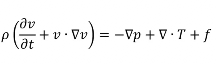

None
torch.Size([1, 64, 216])

Predicted formula:
 <S> \rho \left( \frac { \partial p } { \partial t } + v \cdot v \cdot \nabla _ { \bf p } \right) = - \nabla p + \Psi + \Psi + \Psi + \Psi + \Psi + \nabla \cdot T + F ^ { \prime } + F + F ^ { \prime } \right) = - \nabla _ { r } + F ^ { \prime } + F _ { - } ^ { \prime } <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(64, 455, 3)


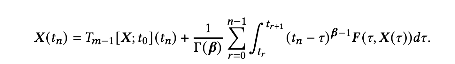

None
torch.Size([1, 64, 455])

Predicted formula:
 <S> \chi ( t _ { r } ) = i _ { m - 1 } [ X , l _ { 0 } ( t _ { m } ) + \frac { 1 } { \Gamma ( P ) } \sum _ { m } ^ { \infty } \int _ { x } ^ { x + 1 } \int _ { x } ^ { x _ { n } } ^ { x _ { n } } ( t _ { n } - r ) ^ { B + 1 } f ( \tau , \chi ( v ) u _ { - } } <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(64, 640, 3)


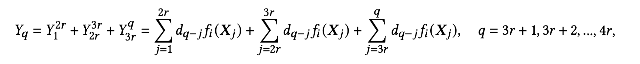

None
torch.Size([1, 64, 640])

Predicted formula:
 <S> Y _ { q } \equiv \prod _ { 1 } ^ { p p + 1 } + \sum _ { j = 1 } ^ { p r } d _ { \ell } ^ { p - p } = \sum _ { j = 2 } ^ { p } d _ { \ell } - f _ { \ell } ^ { p } d \chi _ { \ell } ( X _ { j } ) + \sum _ { r = 3 } ^ { p } d _ { \ell } f _ { \ell } - f ( X _ { j } ) , \quad q = 3 r + 1 , 3 r , <E> <P> <P> <P>


<IPython.core.display.Math object>

None
(64, 562, 3)


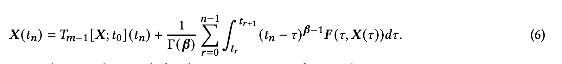

None
torch.Size([1, 64, 562])

Predicted formula:
 <S> X ( t _ { ( r ) } = T _ { m - 1 } ( X _ { n } ) + \frac { 1 } { 1 } \int _ { r = 0 } ^ { r - 1 } \int _ { r = 0 } ^ { r - 1 } \int _ { r = 0 } ^ { r - 1 } f ( t _ { n } - \pi ) \beta ^ { 2 } T ( z , \chi ( ) d \pi ) d \pi <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(64, 135, 3)


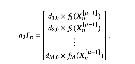

None
torch.Size([1, 64, 135])

Predicted formula:
 <S> \begin{array} { l l l l l l } { 0 } & { } & { } & { } & { } & { 0 } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & {


<IPython.core.display.Math object>

None
(64, 291, 3)


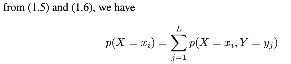

None
torch.Size([1, 64, 291])

Predicted formula:
 <S> \begin{array} { l l l l l l l l l l l l l l l } ( 1 , 3 , s ) = 1 } \\ { \mathrm { l o l o l o l o l } ( N - x , p ) } & { l = 1 } \\ { l ^ { l m a l , s } } & { l ( X - x , P ) = 1 } \\ { l ^ { l } } & { l ( X - x , N - x , P = x , P = 0 ) } \\ \end{array} <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(64, 384, 3)


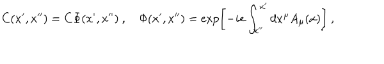

None
torch.Size([1, 64, 384])

Predicted formula:
 <S> \begin{array} { c c c c c c c c c c } { \beta } \\ { } & { \mathrm { G } } & { } & { \mathrm { c } ( s , s ^ { \prime } ) } & { \mathrm { c o f } ( s ^ { \prime } ) } & { \mathrm { c o f } ( s _ { \prime } ^ { \prime } ) } & { \mathrm { c o f } } \\ { } & { } & { \mathrm { c o f } } \\ { } & { } & { \mathrm { c o f } } \\ \end{array} \right. <E> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(64, 114, 3)


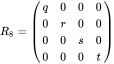

None
torch.Size([1, 64, 114])

Predicted formula:
 <S> R _ { 0 } = \left( \begin{array} { c c c c c c c c c } { 0 } & { 0 } & { 0 } & { 0 } & { 0 } & { 0 } & { 0 } & { 0 } & { 0 } & { 0 } & { 0 } & { 0 } & { 0 } & { 0 } & { 0 } & { 0 } & { 0 } & { 0 } & { 0 } & { 0 } & { 0 } & { 0 } & { 0 } & { 0 } & { 0 } & { 0 } & { 0 } \\ { 0


<IPython.core.display.Math object>

None
(64, 640, 3)


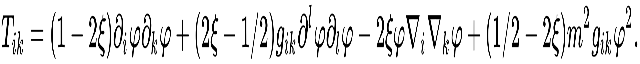

None
torch.Size([1, 64, 640])

Predicted formula:
 <S> T _ { k } = ( 1 - 2 \xi ) \phi \partial _ { k } \varphi + ( 2 \xi - 1 / 2 ) g _ { k l } \partial ^ { l } \varphi \partial _ { l } \varphi - 2 \xi \varphi \nabla _ { k } \nabla _ { k } \varphi + ( 1 / 2 - 2 \xi ) m ^ { 2 } g _ { k l } \varphi ^ { 2 } . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(64, 363, 3)


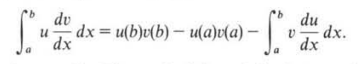

None
torch.Size([1, 64, 363])

Predicted formula:
 <S> \left[ \begin{array} { c c c c } { s } u \frac { d x } { d X } d \chi = u ( b ) \psi ( b ) - i ( a ) \psi ( a ) - \int _ { x } ^ { s } x \frac { s } { d X } \frac { d u } { d X } d X _ { - } . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(64, 474, 3)


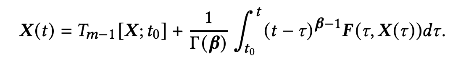

None
torch.Size([1, 64, 474])

Predicted formula:
 <S> { \cal X } ( t ) = T _ { m - 1 } [ X ; t ] + \frac { 1 } { \Gamma ( F ) } \int _ { t _ { 0 } } ^ { t } ( t - \tau ) ^ { \beta - 1 } F ( t , \chi ( \tau ) ) d \pi . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(64, 135, 3)


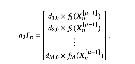

None
torch.Size([1, 64, 135])

Predicted formula:
 <S> \begin{array} { l l l l l l } { 0 } & { } & { } & { } & { } & { 0 } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & {


<IPython.core.display.Math object>

None
(64, 384, 3)


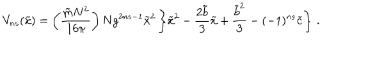

None
torch.Size([1, 64, 384])

Predicted formula:
 <S> \psi _ { a c } G ) = ( \mathrm { S } ^ { \mathrm { i c d } } ) ^ { 3 } + i \gamma ^ { 2 } } { 3 } ^ { 2 } + i \gamma ^ { 2 } \frac { 2 \pi } { 3 } + \frac { 2 \pi } { 3 } + \frac { 2 \pi } { 3 } + \frac { 2 } { 3 } + \frac { 2 } { 3 } + \frac { 2 } { 3 } + ( \tau ) ^ { n } \epsilon } \right] . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(64, 384, 3)


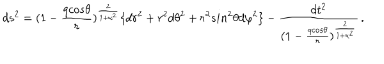

None
torch.Size([1, 64, 384])

Predicted formula:
 <S> \begin{array} { c l l l } { A ^ { 2 } = 0 - \frac { d Q a d s } { 8 } | ^ { 2 } + \sqrt { \pi d s d ^ { 2 } + r ^ { 2 } | 4 \pi s t ^ { 2 } + \sqrt { c ^ { 2 } } + \sqrt { c ^ { 2 } } | ^ { 2 } + \frac { s e ^ { 4 } } { 6 \pi s ^ { 2 } } | - \frac { s e ^ { 2 } } { \sqrt { 2 } } } } & { \mathrm { r } } & { .


<IPython.core.display.Math object>

None
(64, 291, 3)


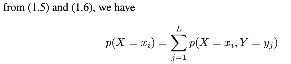

None
torch.Size([1, 64, 291])

Predicted formula:
 <S> \begin{array} { l l l l l l l l l l l l l l l } ( 1 , 3 , s ) = 1 } \\ { \mathrm { l o l o l o l o l } ( N - x , p ) } & { l = 1 } \\ { l ^ { l m a l , s } } & { l ( X - x , P ) = 1 } \\ { l ^ { l } } & { l ( X - x , N - x , P = x , P = 0 ) } \\ \end{array} <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [17]:
for image in IMAGES:
    predict(image)